In [ ]:
!pip install langchain langgraph langchain-openai langchain-community langchain-tavily

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [ ]:
from langgraph.graph import StateGraph , START , END , MessagesState
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
from typing import TypedDict , Literal
from pydantic import BaseModel ,Field
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.messages import HumanMessage

In [ ]:

llm_model = ChatOpenAI()
search_tool = TavilySearch(max_results=4)

In [ ]:
llm_model.invoke("hi").content

'Hello! How can I assist you today?'

In [ ]:
tools = [search_tool]
llm_model_with_tool = llm_model.bind_tools(tools)
tool_node = ToolNode(tools)

In [ ]:
@tool
def get_city_details (prompt) :
  """Only do a web search when need to find the required city details just use this tool to find the details of the city """
  search_response = search_tool.invoke(prompt)
  return search_response

# Pydantic class for the data validation

In [ ]:
class city_structured_detail (BaseModel) :
  """Respond the user with the query releated to the city in this format"""
  state_name : str = Field("State name of the city")
  state_capital : str = Field("State capital of the city")
  country_name : str = Field("Country name of the city")
  country_capital :str = Field("Country capital of the city")

In [ ]:
model_with_strcture_output = llm_model.with_structured_output(city_structured_detail)

/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [ ]:
class AgentState(MessagesState) :
  final_response : city_structured_detail

In [ ]:
def call_model (state : AgentState) :
  print(f"01 input from call model {state}")
  response = llm_model_with_tool.invoke(state['messages'])
  print(f"02 output from call model {response}")
  return {'messages' : [response]}


In [ ]:
def should_continue (state : AgentState) :
  last_message = state['messages'][-1]

# if there is no function call, then we respond to the user
  if not last_message.tool_calls :
    return "respond"
  else :
    return "continue"

In [ ]:
def respond (state : AgentState) :
  print(f"here is 03 state from respond {state}")
  last_message = state['messages'][-1]
  response  = model_with_strcture_output.invoke([HumanMessage(content=state['messages'][-1].content)])
  print(f"this is 04 response from respond{response}")
  return {"final_response": response}

In [ ]:
graph = StateGraph(AgentState)

In [ ]:
graph.add_node("llm" , call_model)
graph.add_node("tool" , tool_node)
graph.add_node("respond" , respond)

graph.add_edge(START , "llm")
graph.add_conditional_edges("llm" , should_continue,{'continue': 'tool' , 'respond':'respond',},)
graph.add_edge("tool" , "llm")
graph.add_edge("llm",END)


In [ ]:
workflow = graph.compile()

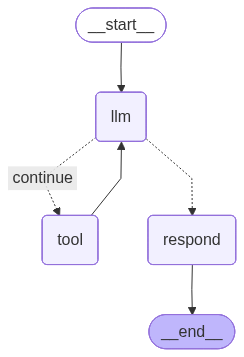

In [ ]:

from IPython.display import Image, display
# View
display(Image(workflow.get_graph().draw_mermaid_png()))

In [ ]:
answer = workflow.invoke(input={"messages":[ "Tell me about the city details for Islamabad?"]})

01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for Islamabad?', additional_kwargs={}, response_metadata={}, id='cfbf0575-adfc-4e38-a7e4-8e231442f16a')]}
02 output from call model content='' additional_kwargs={'tool_calls': [{'id': 'call_JLtN1LVC9uN0bb6BAAns84vZ', 'function': {'arguments': '{"query":"City details for Islamabad"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1343, 'total_tokens': 1362, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CAtbz6QJZISiFLG2d8owFkSkML8cw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--aa6bb6fe-0dd1-441b-9804-36382a6eb59b-0' tool_calls

In [ ]:
answer['final_response']


city_structured_detail(state_name='Islamabad', state_capital='Islamabad', country_name='Pakistan', country_capital='Islamabad')

In [ ]:
answer = workflow.invoke(input={"messages":[ "hi my name is ibtisam"]})

01 input from call model {'messages': [HumanMessage(content='hi my name is ibtisam', additional_kwargs={}, response_metadata={}, id='4ac95b04-6a09-4619-b5ab-e4ac7571b65c')]}
02 output from call model content='Hello Ibtisam! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 1342, 'total_tokens': 1356, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CAu4pkKBxtCNARntnYKe0DYf5LYHX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--e4f886b9-89b8-4702-960f-740430ee9bbe-0' usage_metadata={'input_tokens': 1342, 'output_tokens': 14, 'total_tokens': 1356, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 

In [ ]:
answer['final_response']


city_structured_detail(state_name='State name of the city', state_capital='State capital of the city', country_name='Country name of the city', country_capital='Country capital of the city')